## Read in Libraries

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import seaborn as sns
from umap import UMAP

from sklearn.neighbors import NearestCentroid

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import shap

## Read In and Prepare Data

In [53]:
spotify = pd.read_csv('https://raw.githubusercontent.com/cjsyndergaard/project_486/main/data/spotify_data.csv')


In [9]:
# Notice that the same song has multiple track genres on different lines
spotify[spotify['artists'] == 'Jim Croce'][['track_id', 'artists', 'track_name', 'track_genre']]

,track_id,artists,track_name,track_genre
19700,20A2Xe76p9wxUFLbbzZjTM,Jim Croce,Time in a Bottle,country
34411,20A2Xe76p9wxUFLbbzZjTM,Jim Croce,Time in a Bottle,folk
99601,20A2Xe76p9wxUFLbbzZjTM,Jim Croce,Time in a Bottle,singer-songwriter
102601,20A2Xe76p9wxUFLbbzZjTM,Jim Croce,Time in a Bottle,songwriter


<Axes: xlabel='track_genre'>

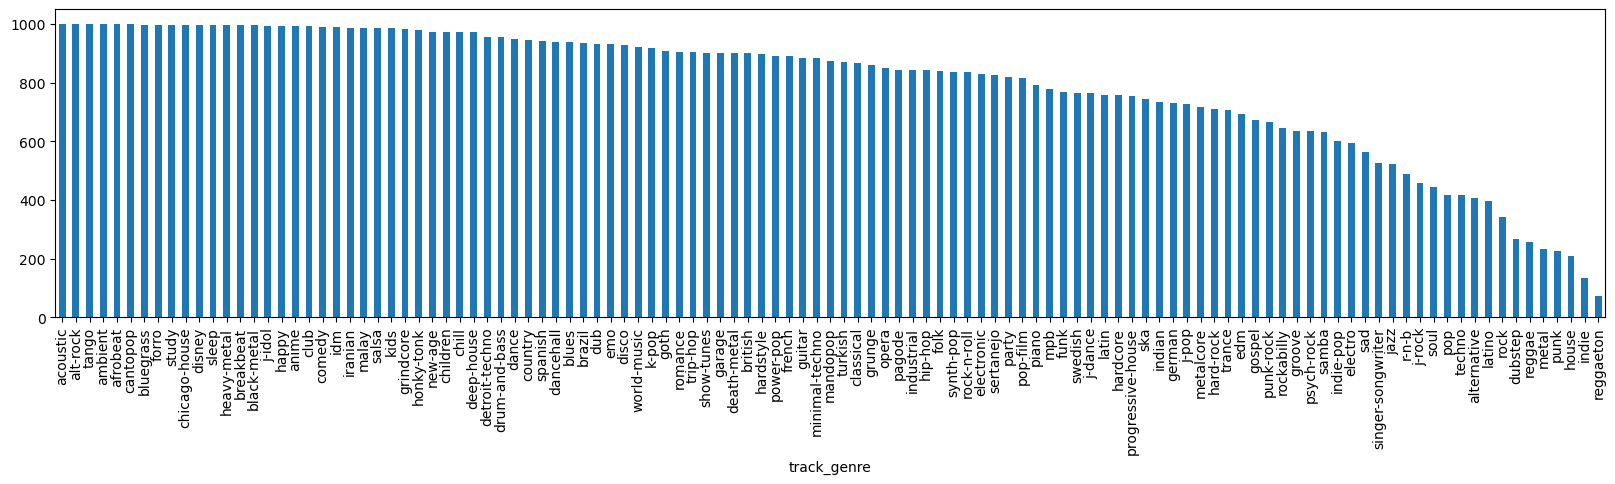

In [27]:
# Keep only one genre per song
spotify = spotify.drop_duplicates(subset=['track_id'], keep='first', ignore_index=True)
x = spotify.iloc[:,5:20]
num_vars = ['popularity', 'duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
x[num_vars] = StandardScaler().fit_transform(x[num_vars])
genre = spotify['track_genre']
genre.value_counts().plot.bar(figsize=(20, 4))

In [29]:
xtrain, xtest, ytrain, ytest = train_test_split(x, genre, random_state=307, test_size=.2)

## Initial Model

0.467379798317455


<Axes: >

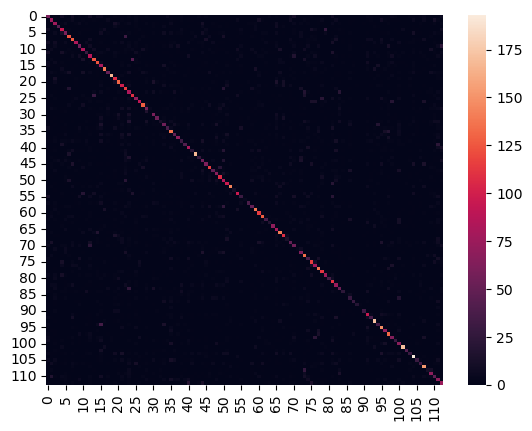

In [30]:
genre_rf = RandomForestClassifier(n_estimators=500, random_state=7567)

genre_rf.fit(xtrain, ytrain)
yhat = genre_rf.predict(xtest)
print(accuracy_score(yhat, ytest))
c =  confusion_matrix(ytest, yhat)
# Clearly, the correct genres are the most likely values, but it is very difficult.
sns.heatmap(c, annot=False)

## Super Genre vs Natural Clusters

In [31]:
# Super genres, chosen with research and domain knowledge
entertainment = ['anime', 'children','disney', 'kids', 'opera', 'show-tunes']
electronic = ['afrobeat', 'ambient', 'breakbeat', 'chicago-house', 'club', 'dance', 'dancehall',
              'deep-house', 'detroit-techno', 'disco', 'dub', 'dubstep', 'edm', 'electro', 'electronic',
              'funk', 'happy', 'house', 'idm',  'industrial', 'minimal-techno', 'progressive-house', 
              'techno', 'trance', 'drum-and-bass']
rock = ['alt-rock', 'black-metal', 'death-metal', 'emo', 'garage', 'goth', 'grindcore', 'groove',
        'grunge', 'hard-rock', 'hardcore', 'hardstyle', 'heavy-metal', 'j-rock', 'metal', 'metalcore',
        'psych-rock', 'punk', 'punk-rock', 'rock', 'rock-n-roll']
pop = ['cantopop', 'hip-hop', 'indie', 'indie-pop', 'j-dance', 'j-idol', 'j-pop', 'k-pop',
       'mandopop', 'party', 'pop', 'pop-film', 'power-pop', 'synth-pop', 'trip-hop', 'alternative']
folk = ['acoustic', 'blues', 'folk', 'honky-tonk', 'jazz', 'r-n-b', 'singer-songwriter', 'soul',
        'bluegrass', 'country', 'guitar', 'rockabilly']
latin = ['latin', 'latino', 'brazil', 'forro', 'mpb', 'pagode', 'reggae', 'reggaeton', 'salsa', 'samba',
         'sertanejo', 'ska', 'spanish', 'tango']
foreign = [ 'british', 'french', 'german', 'indian', 'iranian', 'malay', 'swedish', 'turkish', 'world-music']
easy_listening = ['chill', 'classical', 'gospel', 'new-age', 'piano', 'romance', 'sad', 'sleep', 'study', 'comedy']
super_genres = {'entertainment':entertainment,
                'electronic':electronic,
                'rock':rock,
                'pop':pop,
                'folk':folk,
                'latin':latin,
                'foreign':foreign,
                'easy_listening':easy_listening}

In [32]:
def map_to_supergenre(genre_list, super_genre):
    for i in range(0, genre_list.size):
        for sg, glist in super_genre.items():
            if genre_list.iloc[i] in glist:
                genre_list.iloc[i] = sg
    return genre_list

ytrain_sup = map_to_supergenre(ytrain, super_genres)
ytest_sup = map_to_supergenre(ytest, super_genres)

<Axes: xlabel='track_genre'>

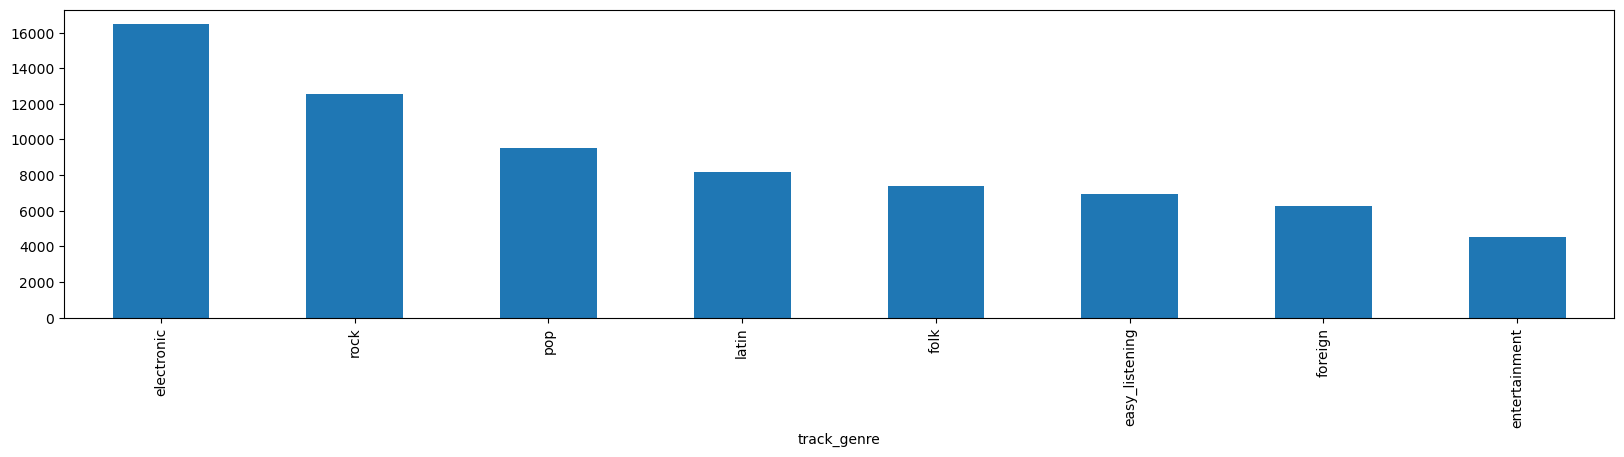

In [33]:
ytrain_sup.value_counts().plot.bar(figsize=(20, 4))

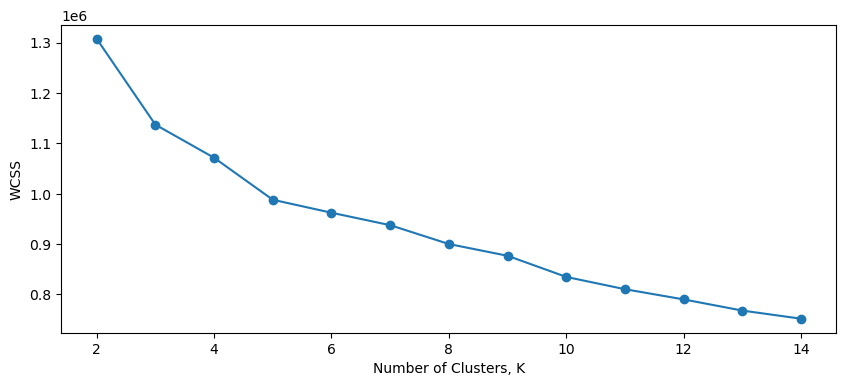

In [34]:
## By cluster
from sklearn.cluster import KMeans
kmeans_per_k = [KMeans(n_clusters=k, n_init='auto', random_state=42).fit(x)
                for k in range(2, 15)]
inertias = [model.inertia_ for model in kmeans_per_k]
plt.figure(figsize=(10,4))
plt.plot(np.arange(2,15),inertias,marker="o")
plt.xlabel('Number of Clusters, K')
plt.ylabel('WCSS')
# 8 is a reasonable number of from the plot, and to make the best comparison with the chosen super-genre, we'll keep that
xtrain_clust, xtest_clust, ytrain_clust, ytest_clust = train_test_split(x, kmeans_per_k[6].labels_, random_state=307, test_size=.2)

In [70]:
## There are, however, there don't seem to be particularly anomoulous tracks at this granularity.
np.unique(ytrain_clust, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([ 4552, 13522,  8185, 11265,  9141, 14645,  4571,  5911],
       dtype=int64))

<BarContainer object of 8 artists>

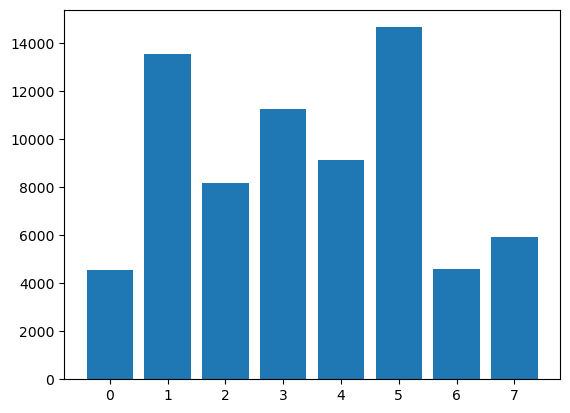

In [72]:
plt.bar(np.unique(ytrain_clust), np.unique(ytrain_clust, return_counts=True)[1])

## Models with Super Genre vs Natural Clusterings

### Random Forests

0.624213048080673


<Axes: >

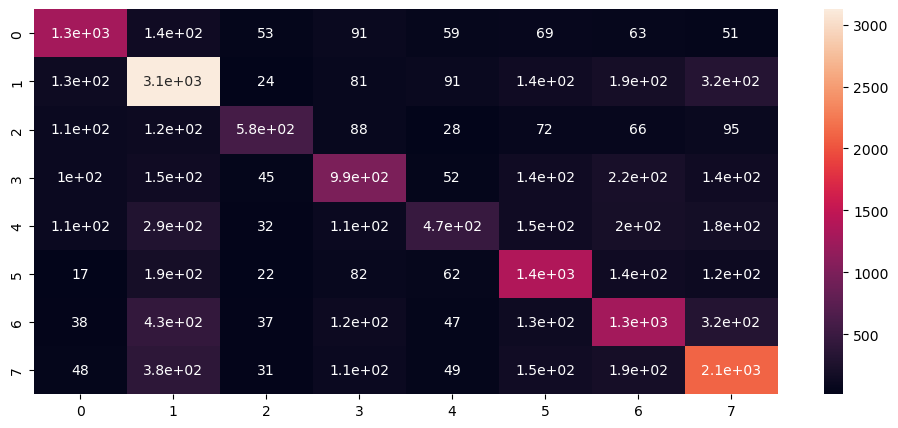

In [36]:
genre_rf2 = RandomForestClassifier(n_estimators=500, random_state=7567)
genre_rf2.fit(xtrain, ytrain_sup)
yhat2 = genre_rf2.predict(xtest)
c2 =  confusion_matrix(ytest_sup, yhat2)
print(accuracy_score(ytest_sup, yhat2))
plt.figure(figsize=(12, 5))
sns.heatmap(c2, annot=True)

In [84]:
# Get in sample
yhat2_train = genre_rf2.predict(xtrain)
print(accuracy_score(yhat2_train, ytrain_sup))

0.9997492756853131


0.9630062956153547


<Axes: >

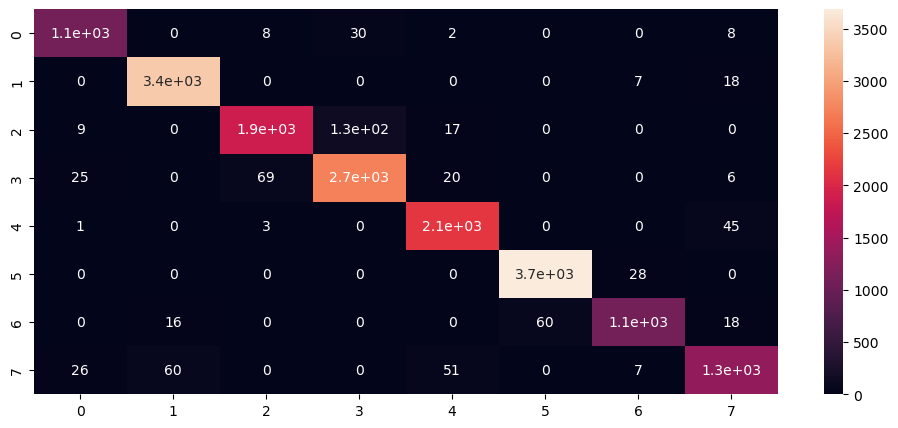

In [37]:
genre_rf3 = RandomForestClassifier(n_estimators=500, random_state=7567)
genre_rf3.fit(xtrain, ytrain_clust)
yhat3 = genre_rf3.predict(xtest)
c3 =  confusion_matrix(ytest_clust, yhat3)
print(accuracy_score(ytest_clust, yhat3))
plt.figure(figsize=(12, 5))
sns.heatmap(c3, annot=True)

In [85]:
# Get in sample
yhat3_train = genre_rf3.predict(xtrain)
print(accuracy_score(yhat3_train, ytrain_clust))

1.0


### Naive Bayes

In [38]:
## NAIVE BAYES
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB().fit(xtrain, ytrain_sup)
yhat_nb = nb.predict(xtest)
cnb =  confusion_matrix(ytest_sup, yhat_nb)
print(accuracy_score(ytest_sup, yhat_nb))

0.3733912752799599


In [86]:
# Get in sample
yhatnb_train = nb.predict(xtrain)
print(accuracy_score(yhatnb_train, ytrain_sup))

0.3685090260753287


In [39]:
nb_clust = GaussianNB().fit(xtrain, ytrain_clust)
yhat_nb_clust = nb_clust.predict(xtest)
cnb_clust =  confusion_matrix(ytest_sup, yhat_nb)
print(accuracy_score(ytest_clust, yhat_nb_clust))

0.9077385926792579


In [91]:
# Get in sample
yhatnbclust_train = nb_clust.predict(xtrain)
print(accuracy_score(yhatnbclust_train, ytrain_clust))

0.9105749944283485


### Non-class Method: Nearest Centroid
This method attempts to perform like KNN without the high cost of prediction, namely by computing centroids of the groups. It turned out to be quite abysmal. 

In [97]:
nc = NearestCentroid().fit(xtrain, ytrain_sup)
yhat_nc = nc.predict(xtest)
c_nc =  confusion_matrix(ytest_sup, yhat_nc)
print(accuracy_score(ytest_sup, yhat_nc))

0.35539584377959776


In [98]:
# Get in sample
yhatnc_train = nc.predict(xtrain)
print(accuracy_score(ytrain_sup, yhatnc_train))

0.35750501448629374


In [99]:
nc_clust = NearestCentroid().fit(xtrain, ytrain_clust)
yhat_nc_clust = nc_clust.predict(xtest)
c_nc_clust =  confusion_matrix(ytest_clust, yhat_nc_clust)
print(accuracy_score(ytest_clust, yhat_nc_clust))

0.9977157501810686


In [101]:
# Get in sample
yhatncclust_train = nc_clust.predict(xtrain)
print(accuracy_score(yhatncclust_train, ytrain_clust))

0.9980359928682861


## UMAP

failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!


Text(0, 0.5, 'Dim 2')

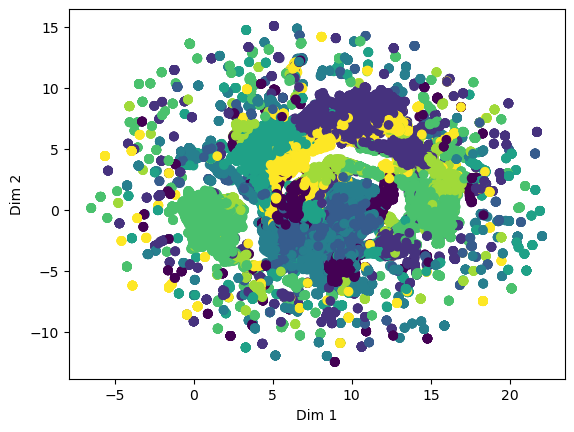

In [42]:
from umap import UMAP
# Dimension reduction was attempted using UMAP, however for computational constraints 5 neighbors were used.
# I played with this for a very long time, and it never got any better.
umap = UMAP(n_neighbors=5)
um_5 = umap.fit_transform(x)
labels = kmeans_per_k[6].labels_.astype(int)
plt.scatter(um_5[:,0],um_5[:,1], c=labels)
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')

## Visualizations and Explanations

In [108]:
xvis = xtrain.loc[:,num_vars]
xvis.columns = num_vars
xvis['genre'] = ytrain_sup
xvis['cluster'] = ytrain_clust
# xvis = xvis.dropna()

In [114]:
xvis.loc[xvis['genre'] == gen[2],num_vars].mean()

popularity         -0.208114
duration_ms        -0.183533
danceability       -0.010584
energy             -0.548183
loudness           -0.221885
speechiness        -0.299517
acousticness        0.607323
instrumentalness   -0.261299
liveness           -0.161605
valence             0.277325
tempo              -0.086642
dtype: float64

In [115]:
gen = ['entertainment', 'latin', 'folk', 'electronic', 'foreign',
       'easy_listening', 'pop', 'rock']
summaries_gen = {}
for g in gen:
    summaries_gen[g] = xvis.loc[xvis['genre'] == g,num_vars].mean()

summaries_clust = {}
for cl in range(8):
    summaries_clust[cl] = xvis.loc[xvis['cluster'] == cl,num_vars].mean()

In [ ]:
for g in gen:
    temp = pd.DataFrame(summaries_gen[g])
    temp.plot.bar(title=f'Super Genre "{g}" Attributes', legend=False)
    plt.savefig(f'figures/attributes/genre_{g}.png', bbox_inches = "tight")

for i in range(8):
    temp = pd.DataFrame(summaries_clust[i])
    temp.plot.bar(title=f'Cluster "{i}" Attributes', legend=False)
    plt.savefig(f'figures/attributes/cluster_{i}.png', bbox_inches = "tight")

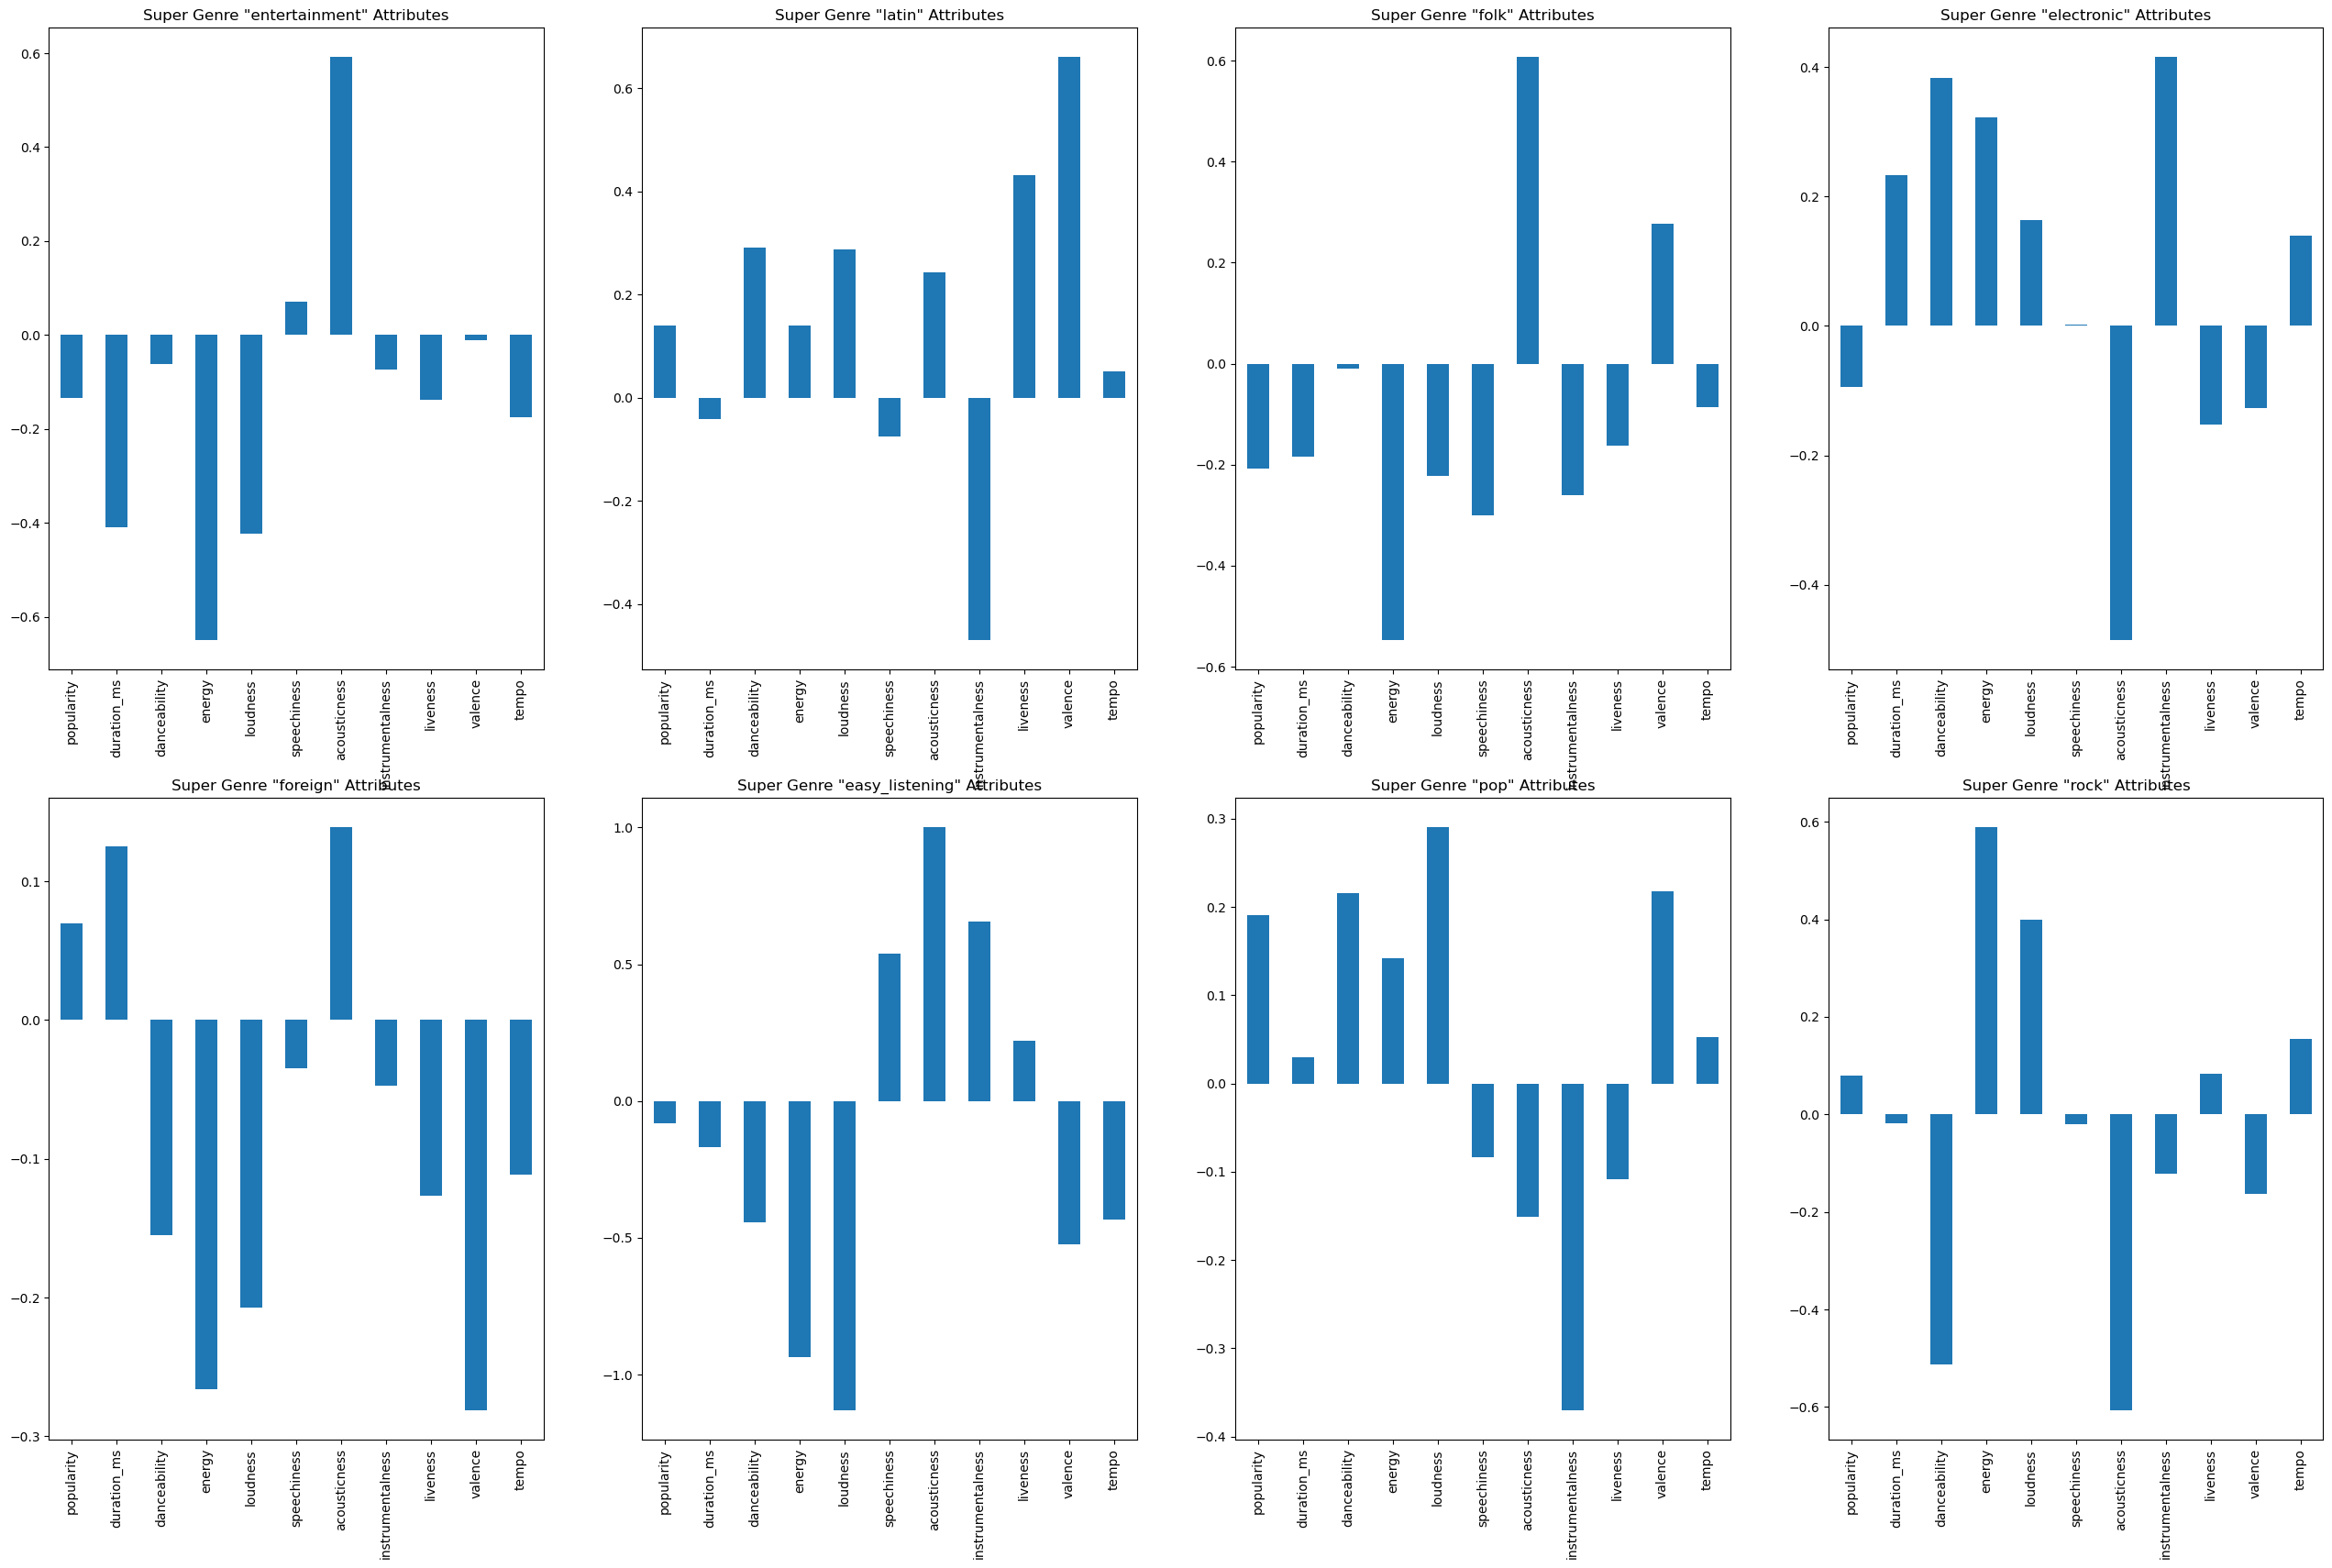

In [116]:
f, axs = plt.subplots(2,4,figsize=(32,20))
for i in range(len(gen)):
    temp = pd.DataFrame(summaries_gen[gen[i]])
    temp.plot.bar(ax=axs[i//4, i%4],title=f'Super Genre "{gen[i]}" Attributes', legend=False)
f.savefig('figures/attributes/super_genre.png', bbox_inches='tight')

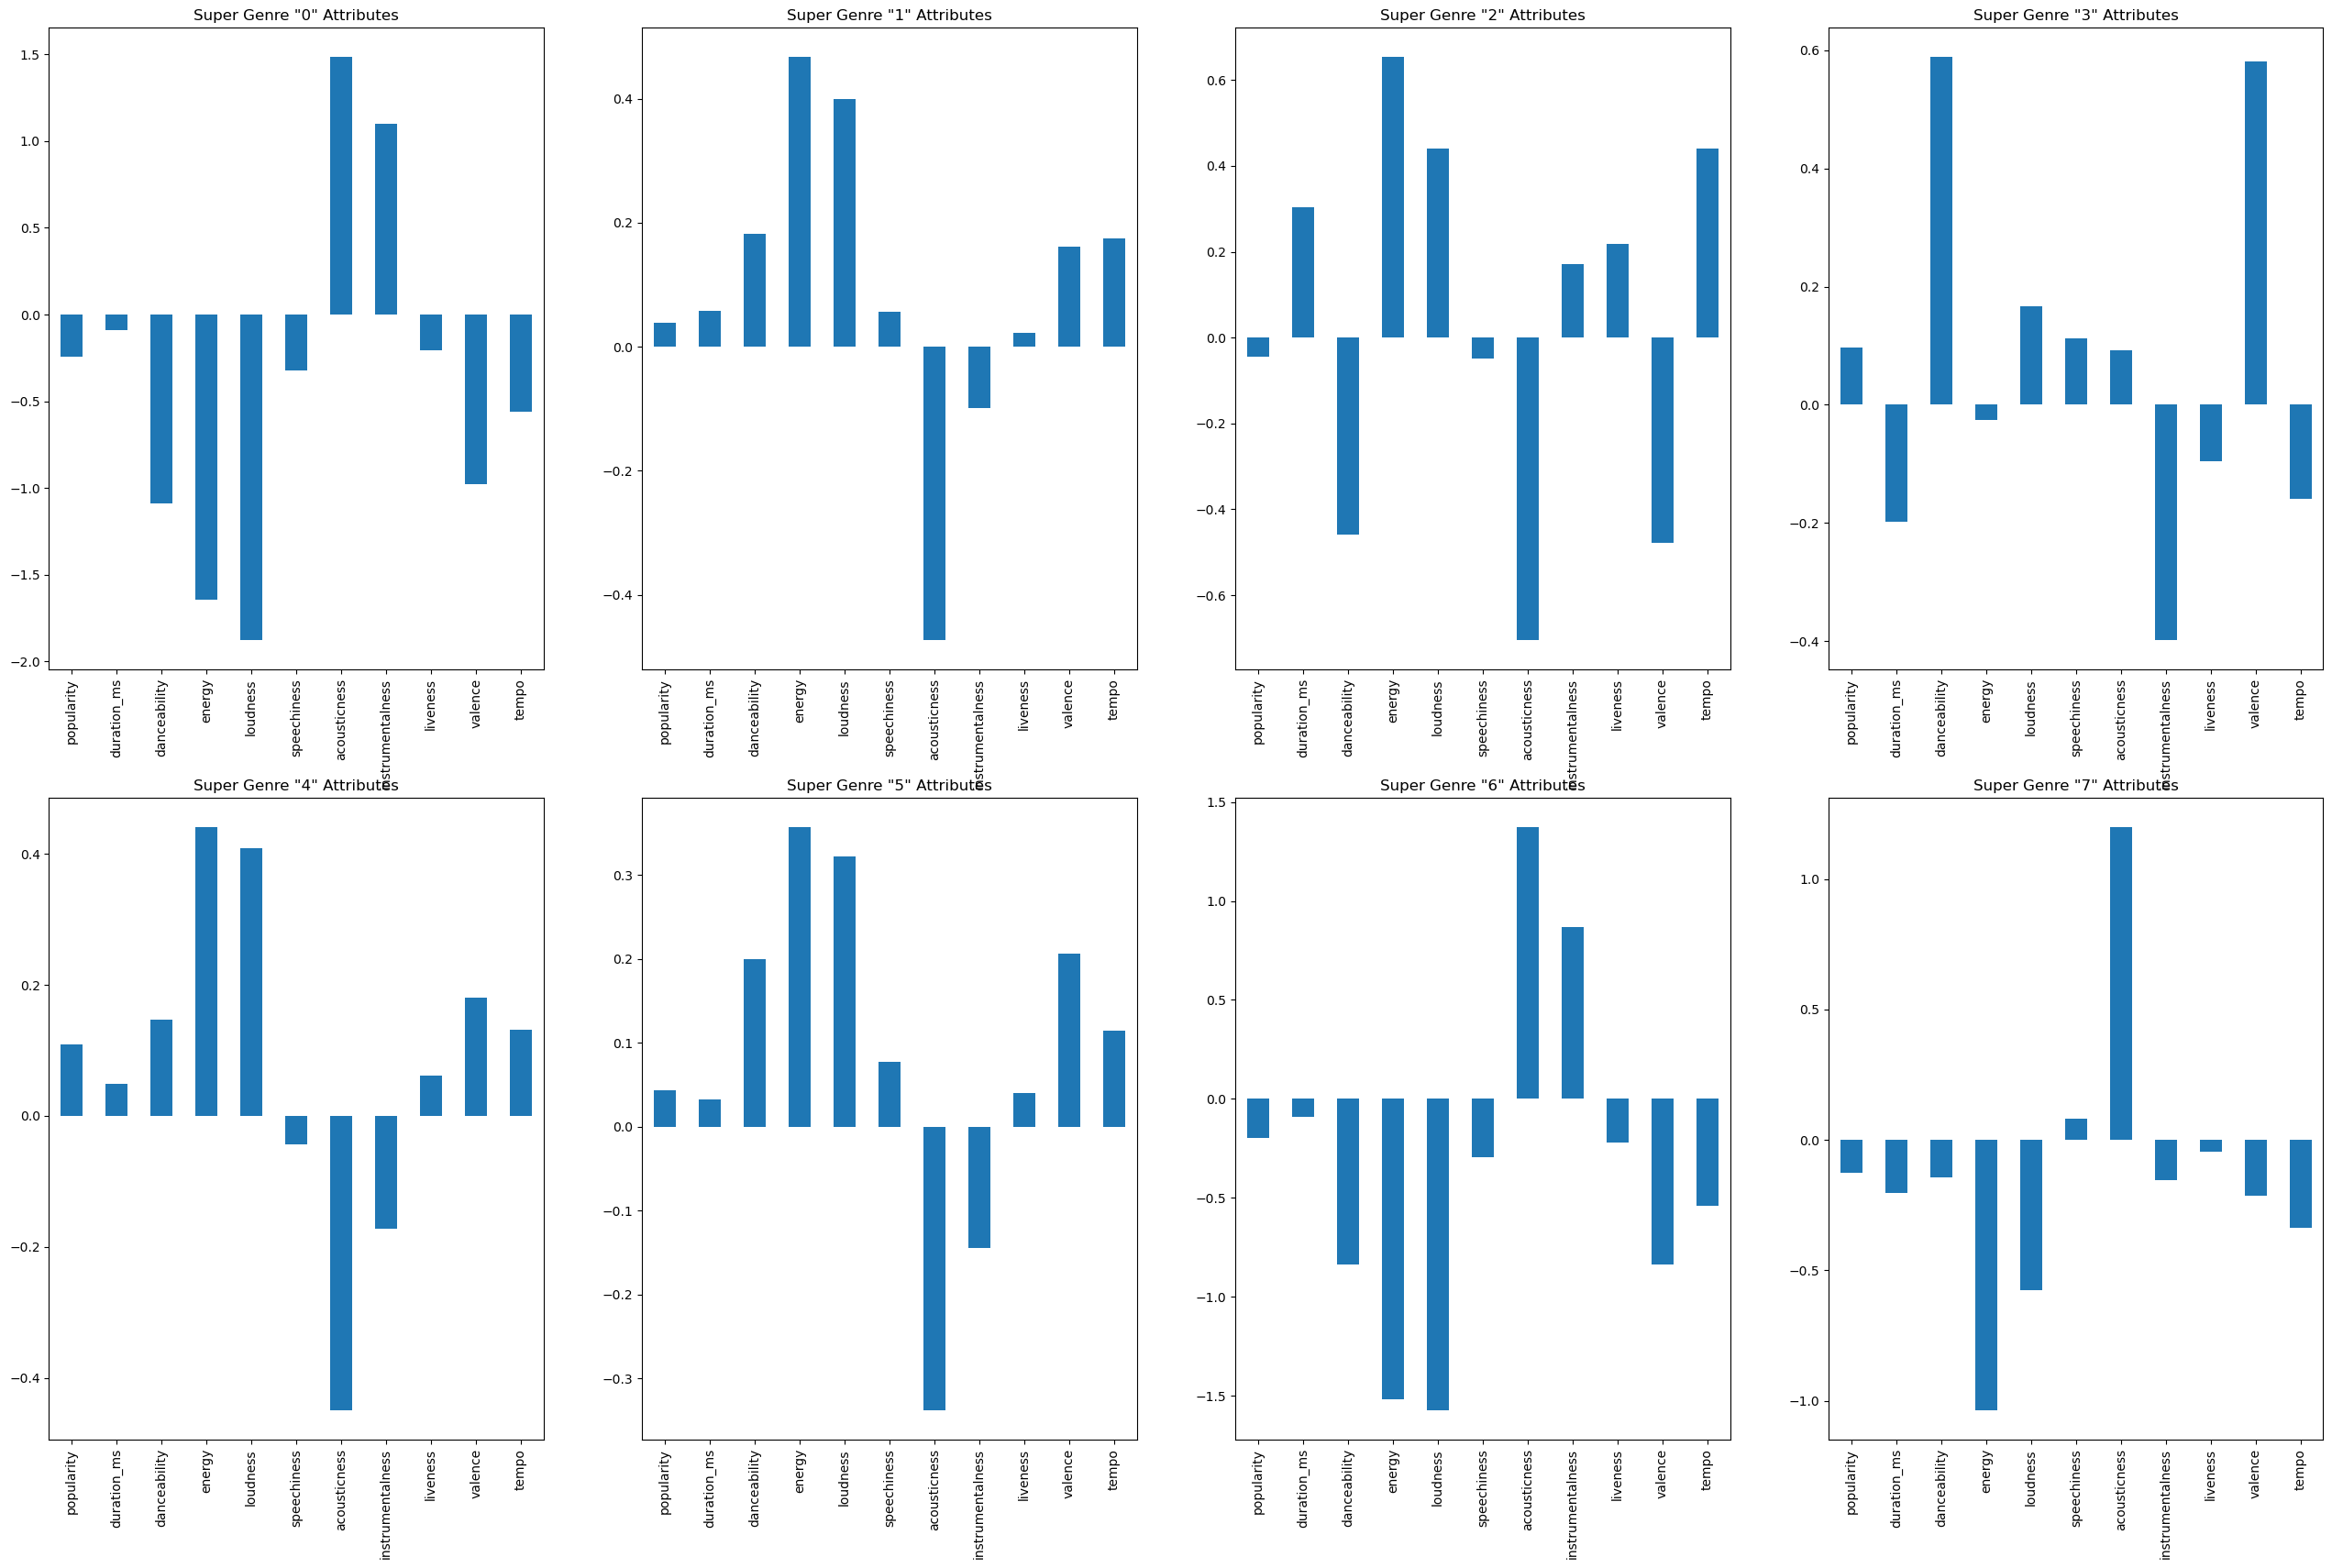

In [117]:
f, axs = plt.subplots(2,4,figsize=(32,20))
for i in range(8):
    temp = pd.DataFrame(summaries_clust[i])
    temp.plot.bar(ax=axs[i//4, i%4],title=f'Super Genre "{i}" Attributes', legend=False)
f.savefig('figures/attributes/clusters.png', bbox_inches='tight')

## SHAP

In [48]:
xshap = xtrain.iloc[np.random.choice(xtrain.shape[0], size=100),:]

explainer_gen = shap.TreeExplainer(genre_rf2)
val_gen = explainer_gen.shap_values(xshap)

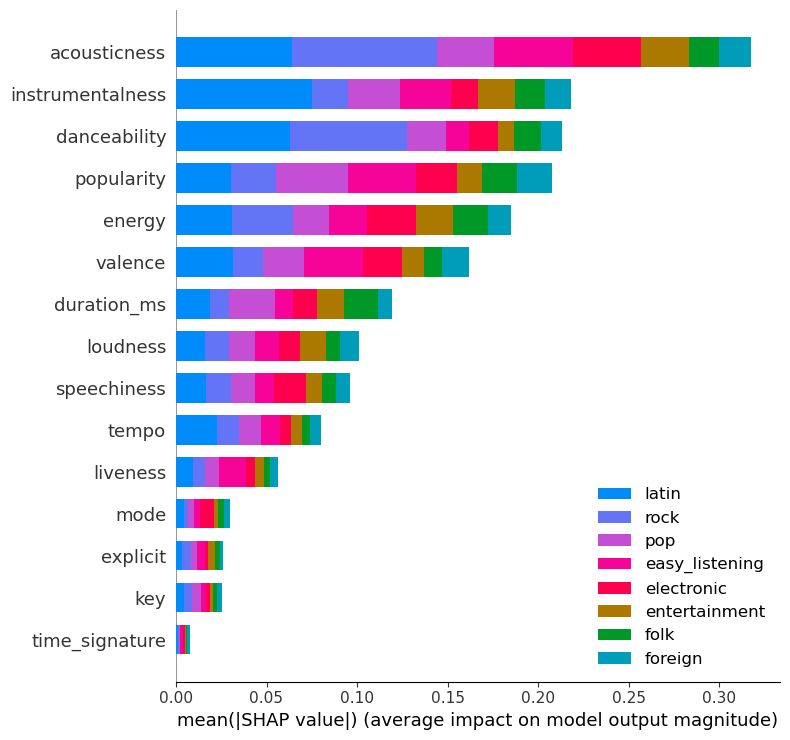

In [49]:
shap.summary_plot(val_gen, xshap.values, plot_type='bar', class_names=gen, feature_names=xshap.columns)

In [50]:
# explainer_clus = shap.TreeExplainer(genre_rf3) 
explainer_clust = shap.TreeExplainer(genre_rf3)
val_clust = explainer_clust.shap_values(xshap)

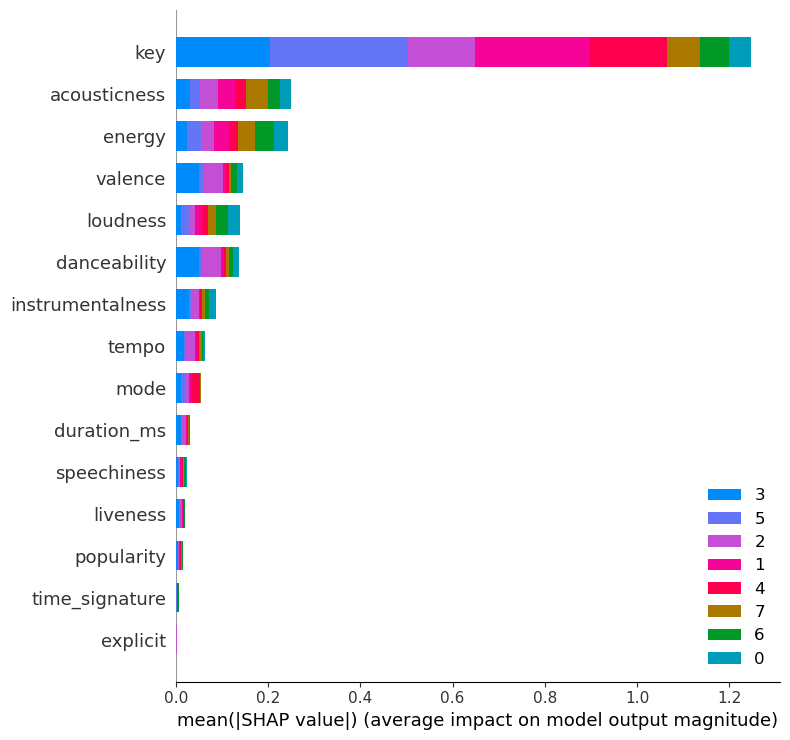

In [51]:
shap.summary_plot(val_clust, xshap.values, plot_type='bar', class_names=range(8), feature_names=xshap.columns)